# Adaptive Moving Mesh Methods

If one wishes to approximate a given function u(x) using its values at a finite number of
mesh points, how should these points be chosen? The answer can usually be given
as follows: one chooses mesh density function ρ(x)

In [144]:
import underworld as uw
import math
from underworld import function as fn
import glucifer
import numpy as np
import scipy as sp
import os
import math
import collections
import itertools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [145]:
def gauss(r,a):
   return np.exp(-r**2/a**2) 

In [146]:
dim = 2

meshX = 64
meshY = 32

In [147]:
# create mesh objects
mesh = uw.mesh.FeMesh_Cartesian( elementType='Q1/dQ0', 
                                         elementRes=(meshX, meshY), 
                                           minCoord=(-1.,0.), 
                                           maxCoord=(1.,1.0))



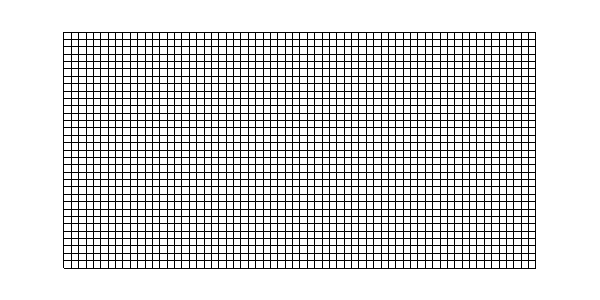

In [7]:
figMesh = glucifer.Figure(figsize=(600,300),antialias=1)
#figMesh.append( glucifer.objects.Mesh(mesh.subMesh, nodeNumbers=True) )
figMesh.append( glucifer.objects.Mesh(mesh, nodeNumbers=False) )
figMesh.show()

In [8]:
axis = 'x'
if axis == "y":
    thisaxis = 1
else:
    thisaxis = 0

dom = np.linspace(mesh.minCoord[thisaxis], mesh.maxCoord[thisaxis], mesh.elementRes[thisaxis]+1)

In [9]:
dom.shape
def get_mesh_spacing(mesh, axis = 'y'):
    if axis == "y":
        thisaxis = 1
    else:
        thisaxis = 0
    dom = np.linspace(mesh.minCoord[thisaxis], mesh.maxCoord[thisaxis], mesh.elementRes[thisaxis]+1)
    return np.diff(dom)

In [10]:
orig= get_mesh_spacing(mesh, axis = 'x')

In [11]:
orig.sum()

2.0

In [12]:
#Lets create some toy mesh density function, and normaize it using the orginal (constant) density

density_norm = (orig + orig.mean()/2.*np.sin((math.pi/1.)* dom[:-1]) + orig.mean()*gauss(dom[:-1],0.1))/orig
space_norm = 1./density_norm

In [13]:
def density_norm_func(x):
    return ((orig.mean() +
            orig.mean()/2.*np.sin((math.pi/1.)* x) +
            orig.mean()*gauss(x,0.1))/orig.mean())

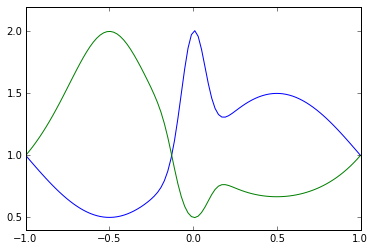

In [14]:
testx = np.linspace(-1.,1., 100)
out = density_norm_func(testx)
pyplot.plot(testx,out)
pyplot.plot(testx,1./out)

In [17]:
density_norm_func(0.5)
mesh.elementRes[thisaxis]
mesh.minCoord[thisaxis]

-1.0

In [19]:
#density_norm_func(loc)

#This is a naive way of making our refined mesh coordinates fit the domain
newcoords = []
loc = 0.
for coord in range((mesh.elementRes[thisaxis] + 1)):
    if i == 0:
        loc = loc
    else: 
        loc += 1./density_norm_func(loc) #spacing is inverse of mesh density function
    print(loc, density_norm_func(loc))
    newcoords.append(loc)
    
newcoords = np.array(newcoords) * (orig.sum()/max(newcoords)) - abs(mesh.minCoord[thisaxis])

In [21]:
newcoords

[]

In [22]:
denity_norm 


NameError: name 'denity_norm' is not defined

In [ ]:
#This is a naive way of making our refined mesh coordinates fit the domain
#newcoords1 = np.cumsum(space_norm*orig.sum()/space_norm.sum()) - abs(mesh.minCoord[thisaxis])
#newcoords2 = orig.sum()/space_norm.sum() * np.cumsum(space_norm - space_norm.mean())

#Add the zeroeth node
#newcoords1 = np.hstack((mesh.minCoord[thisaxis],newcoords1))
#newcoords2 = np.hstack((mesh.minCoord[thisaxis],newcoords2))

In [ ]:
#newcoords

In [ ]:
pyplot.plot(dom[:-1], density_norm, label='New mesh density function')
pyplot.plot(dom[:-1], orig/orig, label='Old mesh density function')
pyplot.plot(dom[:-1], space_norm, label='New mesh space function')
pyplot.plot(dom, newcoords, label='New node coordinates')

pyplot.plot(dom, np.unique(mesh.data[:,thisaxis]), label='Old node coordinates')
pyplot.legend(loc=4)


In [ ]:
coorddict = dict(itertools.izip(dom, newcoords))

In [ ]:
mesh.reset()

In [ ]:

with mesh.deform_mesh():
        for index, coord in enumerate(mesh.data):
            key = mesh.data[index][thisaxis]
            mesh.data[index][thisaxis] = coorddict[key]

In [ ]:
figMesh = glucifer.Figure(figsize=(600,300),antialias=1)
#figMesh.append( glucifer.objects.Mesh(mesh.subMesh, nodeNumbers=True) )
figMesh.append( glucifer.objects.Mesh(mesh, nodeNumbers=False) )
figMesh.show()

In [ ]:
mesh.maxCoord

##  A numerical method for the problem

In [21]:
#elements
res = 10

In [22]:
# create mesh objects
mesh = np.linspace(0.,1., res + 1)
dx = 1./res
BC0 = 0.
BC1 = 1.

In [23]:

len(mesh)

11

In [31]:
#Create central difference Gradient operator
a = np.ones((1, res-1))[0]
b = np.ones((1, res-2))[0]
A = np.diag(a, 0)*-1. + np.diag(b, 1)

In [32]:
A

array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])

In [52]:
#create our mesh density function 
def mesh_density(x):
    return dx + (dx/2)*np.sin(2*math.pi/1.*x)

In [53]:
B = mesh_density(mesh[1:-1])


In [54]:
#RHS 
B = mesh_density(mesh[1:-1])
#B= copy(mesh[1:-1])
#B[:] = dx
#BCs
print(B)
B[-1] = B[-1] - BC1
result = numpy.linalg.solve(A, B)
result 


[ 0.12938926  0.14755283  0.14755283  0.12938926  0.1         0.07061074
  0.05244717  0.05244717  0.07061074]


array([ 0.1       ,  0.22938926,  0.37694209,  0.52449491,  0.65388418,
        0.75388418,  0.82449491,  0.87694209,  0.92938926])

In [55]:
mesh

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

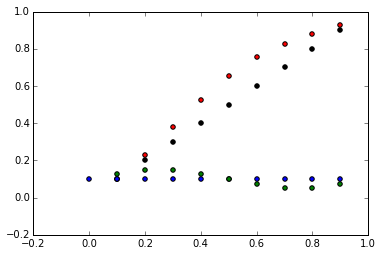

In [56]:
pyplot.scatter(mesh[1:-1], result, c = 'r')
pyplot.scatter(mesh[1:-1], mesh[1:-1], c='k')
pyplot.scatter(mesh[:-1], [dx]*res)
pyplot.scatter(mesh[1:-1], mesh_density(mesh[1:-1]), c = 'g')
#pyplot.plot(mesh_density(mesh[1:-1])/dx)

This approach works when the mesh-density integral is normalised, i.e is equal to the domain width. 

In [315]:
np.dot(A,result)

array([ 0.00174214,  0.00346519,  0.00515028,  0.00677894,  0.00833333,
        0.00979642,  0.01115218,  0.01238575,  0.01348362,  0.01443376,
        0.01522576,  0.01585094,  0.01630246,  0.01657536,  0.01666667,
        0.01657536,  0.01630246,  0.01585094,  0.01522576,  0.01443376,
        0.01348362,  0.01238575,  0.01115218,  0.00979642,  0.00833333,
        0.00677894,  0.00515028,  0.00346519,  0.00174214])

0.31801894479547027

In [259]:
for t in range(10):
    #RHS 
    #B = mesh_density(mesh[1:-1])
    #B = mesh_density(mesh[1:-1])
    B= copy(mesh[1:-1])
    B[:] = dx
    #BCs
    B[0]  = B[0] + BC0
    B[-1] = B[-1] - BC1
    newpos = numpy.linalg.solve(A, B)
    mesh[1:-1] = newpos
    #print  B, newpos

In [260]:
np.dot(A,newpos)

array([ 0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333, -0.96666667])

In [261]:
newpos[-1]

0.96666666666666667

In [262]:

B

array([ 0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
        0.03333333,  0.03333333,  0.03333333, -0.96666667])

## 1D Spring methods

In [57]:
"""
Created on Thu May 08 07:07:24 2014
 
@author: Sukhbinder Singh
 
Truss FEM
 
"""
from __future__ import division
import numpy as np
 
modE=30.0e6
Area=2.0
 
 
#numElem=3
#numNodes=4
 
elemNodes=np.array([[0,1],[0,2],[0,3]])
nodeCords=np.array([[0.0,0.0],[0.0,120.0],[120.0,120.0],[120.0,0]])
 
#'''
elemNodes=np.array([[0,1],[0,2],[1,2],[1,3],
                    [0,3],[2,3],[2,5],[3,4],[3,5],[2,4],[4,5]])
 
nodeCords=np.array([
[0.0,0.0],[0.0,3000.0],
[3000.0,0.0],[3000.0,3000.0],
[6000.0,0.0],[6000.0,3000.0]
])
 
 
modE=70000
Area=300
#'''
 
numElem=elemNodes.shape[0]
numNodes=nodeCords.shape[0]
 
xx=nodeCords[:,0]
yy=nodeCords[:,1]
 
EA=modE*Area
tdof = 2*numNodes #total number of degrees of freedom
disps=np.zeros((tdof,1))
force=np.zeros((tdof,1))
sigma=np.zeros((numElem,1))
stiffness=np.zeros((tdof,tdof))
np.set_printoptions(precision=3)
 
'''
force[1]=-10000.0
presDof=np.arange(2,9)
 
'''
force[3]=-50000.0
force[7]=-100000.0
force[11]=-50000.0
 
presDof=np.array([0,1,9])
#'''
 
for e in xrange(numElem):
    indice= elemNodes[e,:]
    elemDof=np.array([indice[0]*2, indice[0]*2+1, indice[1]*2, indice[1]*2+1 ])
    xa=xx[indice[1]]-xx[indice[0]]
    ya=yy[indice[1]]-yy[indice[0]]
    len_elem=np.sqrt(xa*xa+ya*ya)
    c=xa/len_elem
    s=ya/len_elem
    k1=(EA/len_elem)* np.array([[c*c,c*s,-c*c, -c*s],
                                [c*s,s*s,-c*s ,-s*s],
                                [-c*c,-c*s,c*c,c*s],
                                [-c*s,-s*s,c*s,s*s]])
    stiffness[np.ix_(elemDof,elemDof)] +=k1
 
 
actDof=np.setdiff1d(np.arange(tdof),presDof)
 
disp1=np.linalg.solve(stiffness[np.ix_(actDof,actDof)],force[np.ix_(actDof)]);
disps[np.ix_(actDof)]=disp1
 
 
# stresses at elements
 
for e in xrange(numElem):
    indice= elemNodes[e,:]
    elemDof=np.array([indice[0]*2, indice[0]*2+1, indice[1]*2, indice[1]*2+1 ])
    xa=xx[indice[1]]-xx[indice[0]]
    ya=yy[indice[1]]-yy[indice[0]]
    len_elem=np.sqrt(xa*xa+ya*ya)
    c=xa/len_elem
    s=ya/len_elem
    sigma[e] = (modE/len_elem) * np.dot(np.array([-c,-s,c,s]),disps[np.ix_(elemDof)])
 
         
print disps
print sigma
 
react = np.dot(stiffness,disps)
print react.reshape((numNodes,2))

[[  0.   ]
 [  0.   ]
 [  7.143]
 [ -9.039]
 [  5.247]
 [-16.296]
 [  5.247]
 [-20.088]
 [ 10.494]
 [  0.   ]
 [  3.351]
 [ -9.039]]
[[-210.902]
 [ 122.432]
 [  62.558]
 [ -44.235]
 [-173.145]
 [ -88.47 ]
 [  62.558]
 [-173.145]
 [ -44.235]
 [ 122.432]
 [-210.902]]
[[ -2.183e-11   1.000e+05]
 [ -3.638e-12  -5.000e+04]
 [ -1.273e-11  -1.637e-11]
 [  3.638e-12  -1.000e+05]
 [ -7.276e-12   1.000e+05]
 [ -3.638e-12  -5.000e+04]]


In [1]:
import networkx as nx
import random

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 23 days


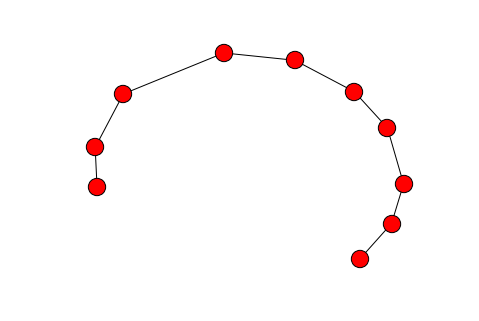

In [61]:

G = nx.path_graph(10)

# Add some random weights (as dictonary with edges as key and weight as value).
nx.set_edge_attributes(G, 'my_weight', dict(zip(G.edges(), [random.random()*10 for edge in G.edges()])))

# Apply layout using weights.
pos = nx.spring_layout(G, weight='my_weight')
nx.draw(G, pos)

In [62]:
pos

{0: array([ 0.006,  0.346]),
 1: array([ 0.   ,  0.541]),
 2: array([ 0.091,  0.801]),
 3: array([ 0.417,  1.   ]),
 4: array([ 0.647,  0.964]),
 5: array([ 0.84 ,  0.812]),
 6: array([ 0.947,  0.636]),
 7: array([ 1.   ,  0.363]),
 8: array([ 0.961,  0.171]),
 9: array([ 0.859,  0.   ])}

In [2]:
G = nx.grid_2d_graph(10, 10)
# Add some random weights (as dictonary with edges as key and weight as value).
#nx.set_edge_attributes(G, 'my_weight', dict(zip(G.edges(), [random.random()*10 for edge in G.edges()])))

# Apply layout using weights.
#pos = nx.spring_layout(G, weight='my_weight')
nx.draw(G)

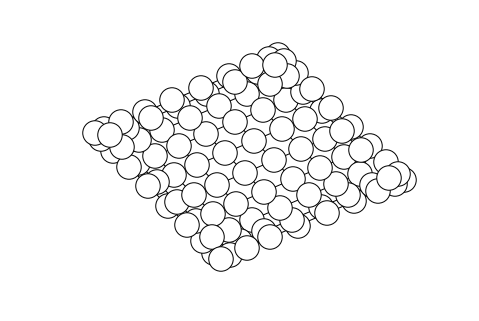

In [10]:
G2 = nx.DiGraph(G)
for edge in G2.edges():
    if edge != tuple(sorted(edge)):
        G2.remove_edge(*edge)

nx.draw_spectral(G2,node_size=600,node_color='w')

In [27]:
n = nx.node_boundary?

In [ ]:
n = nx.node_boundary

In [42]:
labels 

{(0, 0): 0,
 (0, 1): 1,
 (0, 2): 2,
 (1, 0): 10,
 (1, 1): 11,
 (1, 2): 12,
 (2, 0): 20,
 (2, 1): 21,
 (2, 2): 22,
 (3, 0): 30,
 (3, 1): 31,
 (3, 2): 32,
 (4, 0): 40,
 (4, 1): 41,
 (4, 2): 42,
 (5, 0): 50,
 (5, 1): 51,
 (5, 2): 52}

In [44]:
pos

{(0, 0): (0, 0),
 (0, 1): (0, 1),
 (0, 2): (0, 2),
 (1, 0): (1, 0),
 (1, 1): (1, 1),
 (1, 2): (1, 2),
 (2, 0): (2, 0),
 (2, 1): (2, 1),
 (2, 2): (2, 2),
 (3, 0): (3, 0),
 (3, 1): (3, 1),
 (3, 2): (3, 2),
 (4, 0): (4, 0),
 (4, 1): (4, 1),
 (4, 2): (4, 2),
 (5, 0): (5, 0),
 (5, 1): (5, 1),
 (5, 2): (5, 2)}

In [94]:
nx.spring_layout


<function networkx.drawing.layout.fruchterman_reingold_layout>

In [60]:
dict(zip(G, range(len(G))))

{(0, 0): 3,
 (0, 1): 0,
 (0, 2): 16,
 (1, 0): 14,
 (1, 1): 8,
 (1, 2): 1,
 (2, 0): 9,
 (2, 1): 7,
 (2, 2): 11,
 (3, 0): 4,
 (3, 1): 6,
 (3, 2): 2,
 (4, 0): 17,
 (4, 1): 15,
 (4, 2): 13,
 (5, 0): 10,
 (5, 1): 12,
 (5, 2): 5}

In [70]:
nx.spring_layout?

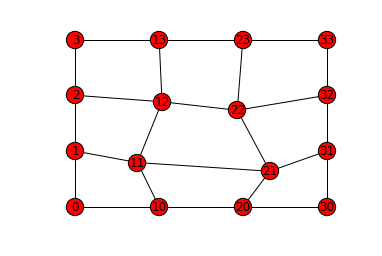

In [139]:
N = 4
G=nx.grid_2d_graph(N,N)
pos = dict( (n, n) for n in G.nodes() )
labels = dict( ((i, j), i * 10 + j) for i, j in G.nodes() )
nx.set_edge_attributes(G, 'my_weight', dict(zip(G.edges(), [random.random()*10 for edge in G.edges()])))

# Apply layout using weights.


pos = nx.spring_layout(G, k=1, pos=pos, weight='my_weight', fixed = [(0, 0), (0, 1), (0,2), (0,3), (1,3),(2,3),(3,3), (3,2),(3,1),(3,0),(2,0),(1,0)])
#pos = nx.spring_layout(G, k=1, pos=pos,  fixed = [(0, 0), (0, 1), (0,2), (0,3), (1,3),(2,3),(3,3), (3,2),(3,1),(3,0),(2,0),(1,0)])



nx.draw_networkx(G, pos=pos, labels=labels)

plt.axis('off')
plt.show()
#pos

In [143]:
test = nx.to_numpy_matrix(G)
test[0:4,0:4]

matrix([[ 0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.]])

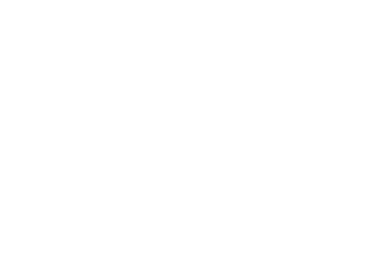

In [21]:
G=nx.grid_2d_graph(10,10)        
nx.draw?

plt.axis('off')
plt.show()

AssertionError: 

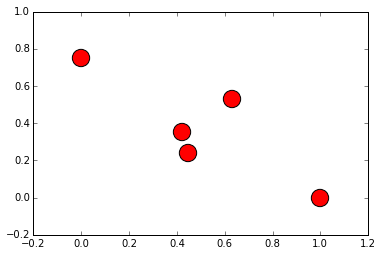

In [97]:
#3D
G=nx.complete_graph(5)
pos=nx.spring_layout(G,dim=3)


In [99]:
nx.spring_layout?

## Springs:

https://cs.nyu.edu/~dzorin/numcomp08/springs.py
https://cs.nyu.edu/~dzorin/numcomp08/springs_notes.pdf